In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import torch 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import glob
from PIL import Image
import os
import math

In [0]:
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

In [0]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

In [0]:
ssd_model.to('cuda')
ssd_model.eval()

In [0]:
uris = glob.glob('/content/drive/My Drive/colab/VisDrone2019-DET-val/images/*.jpg')

In [0]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

In [0]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [0]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.00) for results in results_per_input]

In [0]:
classes_to_labels = utils.get_coco_object_dictionary()

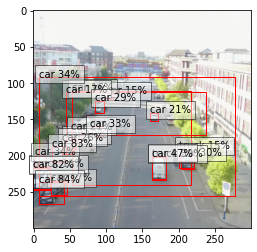

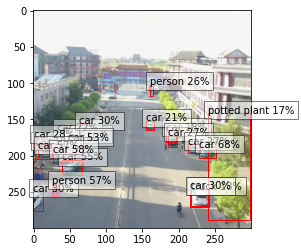

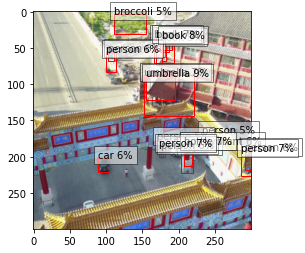

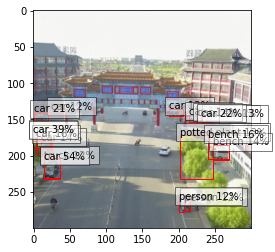

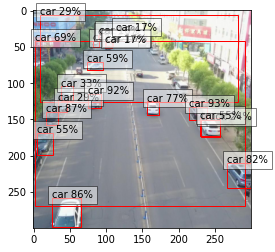

In [11]:
for image_idx in np.arange(285,290,1):
    fig, ax = plt.subplots(1)
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [0]:
annotations_list = glob.glob('/content/drive/My Drive/colab/VisDrone2019-DET-val/annotations/*.txt')

In [0]:
directory = '/content/drive/My Drive/colab/VisDrone2019-DET-val/annotations/'
name_annotation = os.listdir(directory)

In [0]:
annotation = []
for i in annotations_list:
  annotation.append(np.genfromtxt(i, delimiter = ',', dtype = np.float))

In [0]:
def parcing_in(names_files, l_annotation):
  DF = pd.DataFrame(np.zeros((1, 9)),columns=['bbox_left','bbox_top','bbox_width','bbox_height','score','object_category','truncation','occlusion','name_file']) 
  DF = DF.drop([0],axis=0)
  for i in range(len(names_files)):
    df1 = pd.DataFrame(np.matrix(l_annotation[i]), columns=['bbox_left','bbox_top','bbox_width','bbox_height','score','object_category','truncation','occlusion'])
    df2 = pd.Series(np.full(len(np.matrix(l_annotation[i])),names_files[i][0:-4])) 
    df1['name_file'] = df2 
    DF = DF.append(df1,ignore_index=True)
  return DF

In [0]:
df_annotation_true = parcing_in(name_annotation,annotation)

In [17]:
df_annotation_true

,bbox_left,bbox_top,bbox_width,bbox_height,score,object_category,truncation,occlusion,name_file
0,421.0,583.0,99.0,154.0,1.0,4.0,0.0,0.0,0000289_05801_d_0000840
1,607.0,500.0,52.0,105.0,1.0,8.0,0.0,0.0,0000289_05801_d_0000840
2,413.0,491.0,149.0,109.0,1.0,4.0,0.0,0.0,0000289_05801_d_0000840
3,488.0,366.0,73.0,87.0,1.0,4.0,0.0,0.0,0000289_05801_d_0000840
4,503.0,312.0,54.0,65.0,1.0,4.0,0.0,1.0,0000289_05801_d_0000840
...,...,...,...,...,...,...,...,...,...
40164,749.0,292.0,46.0,50.0,0.0,0.0,0.0,0.0,0000333_02549_d_0000014
40165,799.0,291.0,16.0,8.0,1.0,1.0,0.0,1.0,0000333_02549_d_0000014
40166,801.0,300.0,16.0,8.0,1.0,1.0,0.0,1.0,0000333_02549_d_0000014
40167,799.0,330.0,10.0,8.0,1.0,1.0,0.0,0.0,0000333_02549_d_0000014


In [0]:
directory = '/content/drive/My Drive/colab/VisDrone2019-DET-val/images/'
name_foto = os.listdir(directory)

In [0]:
def parcing_out(names_files, l_annotation):
  DF = pd.DataFrame(np.zeros((1, 7)),columns=['bbox_left','bbox_top','bbox_width','bbox_height','classes','confidences','name_file']) 
  DF = DF.drop([0],axis=0)
  for i in range(len(names_files)):
    for j in range(len(l_annotation[i][0])):
      left = l_annotation[i][0][j][0]
      bot = l_annotation[i][0][j][1]
      right = l_annotation[i][0][j][2]
      top = l_annotation[i][0][j][3]
      l_annotation[i][0][j][0] = 300 * left
      l_annotation[i][0][j][1] = 300 * bot
      l_annotation[i][0][j][2] = 300 * (right - left)
      l_annotation[i][0][j][3] = 300 *(top - bot)
    df1 = pd.DataFrame(l_annotation[i][0], columns=['bbox_left','bbox_top','bbox_width','bbox_height'])
    df2 = pd.Series(np.full(len(np.matrix(l_annotation[i][0])),names_files[i][0:-4])) 
    df1['classes'] = pd.Series(l_annotation[i][1])
    df1['confidences'] = pd.Series(l_annotation[i][2])
    df1['name_file'] = df2 
    DF = DF.append(df1,ignore_index=True)
  return DF

In [0]:
df_annotation_received = parcing_out(name_foto,best_results_per_input)

In [21]:
df_annotation_received 

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file
0,99.623520,167.274109,17.036623,25.340366,14.0,0.074748,0000021_00000_d_0000001
1,69.610023,116.437965,236.302475,91.588531,1.0,0.077123,0000021_00000_d_0000001
2,166.208099,151.490616,6.326044,17.915653,1.0,0.077328,0000021_00000_d_0000001
3,164.145508,152.750870,3.884482,7.707202,1.0,0.078046,0000021_00000_d_0000001
4,197.916016,106.741852,2.954435,7.522577,1.0,0.079415,0000021_00000_d_0000001
...,...,...,...,...,...,...,...
10767,199.896027,60.889133,13.895166,14.755516,3.0,0.249358,0000001_05249_d_0000009
10768,78.957100,266.935364,46.184368,30.716587,68.0,0.259822,0000001_05249_d_0000009
10769,110.667953,73.021454,78.561966,74.463173,6.0,0.385268,0000001_05249_d_0000009
10770,118.306381,153.480270,22.223675,23.065996,3.0,0.825118,0000001_05249_d_0000009


In [0]:
classes = pd.DataFrame(classes_to_labels, columns = ['class'])

In [0]:
list_width = []
list_height = []

for i in range(len(uris)):
  im = Image.open(uris[i])
  (width, height) = im.size
  list_width.append(width)
  list_height.append(height)

In [0]:
list_coeff = []
for i in range(len(list_height)):
  list_coeff.append(300 / list_height[i]) 

In [0]:
df_annotation_true_2 = df_annotation_true.copy()

In [26]:
df_annotation_true_2 

,bbox_left,bbox_top,bbox_width,bbox_height,score,object_category,truncation,occlusion,name_file
0,421.0,583.0,99.0,154.0,1.0,4.0,0.0,0.0,0000289_05801_d_0000840
1,607.0,500.0,52.0,105.0,1.0,8.0,0.0,0.0,0000289_05801_d_0000840
2,413.0,491.0,149.0,109.0,1.0,4.0,0.0,0.0,0000289_05801_d_0000840
3,488.0,366.0,73.0,87.0,1.0,4.0,0.0,0.0,0000289_05801_d_0000840
4,503.0,312.0,54.0,65.0,1.0,4.0,0.0,1.0,0000289_05801_d_0000840
...,...,...,...,...,...,...,...,...,...
40164,749.0,292.0,46.0,50.0,0.0,0.0,0.0,0.0,0000333_02549_d_0000014
40165,799.0,291.0,16.0,8.0,1.0,1.0,0.0,1.0,0000333_02549_d_0000014
40166,801.0,300.0,16.0,8.0,1.0,1.0,0.0,1.0,0000333_02549_d_0000014
40167,799.0,330.0,10.0,8.0,1.0,1.0,0.0,0.0,0000333_02549_d_0000014


In [0]:
height = pd.Series(list_height)
width = pd.Series(list_width)
compression_ratio = pd.Series(list_coeff)

In [0]:
df = pd.DataFrame({"name_file":name_foto,"height":height,"width":width,"compression_ratio":compression_ratio})

In [0]:
for i in range(len(list_coeff)):
  df.name_file[i] = df.name_file[i][0:-4]


In [0]:
df_annotation_true_2 = df_annotation_true_2.merge(df,how='left',left_on = 'name_file',right_on = 'name_file')

In [31]:
df_annotation_true_2

,bbox_left,bbox_top,bbox_width,bbox_height,score,object_category,truncation,occlusion,name_file,height,width,compression_ratio
0,421.0,583.0,99.0,154.0,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,765,1360,0.392157
1,607.0,500.0,52.0,105.0,1.0,8.0,0.0,0.0,0000289_05801_d_0000840,765,1360,0.392157
2,413.0,491.0,149.0,109.0,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,765,1360,0.392157
3,488.0,366.0,73.0,87.0,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,765,1360,0.392157
4,503.0,312.0,54.0,65.0,1.0,4.0,0.0,1.0,0000289_05801_d_0000840,765,1360,0.392157
...,...,...,...,...,...,...,...,...,...,...,...,...
40164,749.0,292.0,46.0,50.0,0.0,0.0,0.0,0.0,0000333_02549_d_0000014,765,1360,0.392157
40165,799.0,291.0,16.0,8.0,1.0,1.0,0.0,1.0,0000333_02549_d_0000014,765,1360,0.392157
40166,801.0,300.0,16.0,8.0,1.0,1.0,0.0,1.0,0000333_02549_d_0000014,765,1360,0.392157
40167,799.0,330.0,10.0,8.0,1.0,1.0,0.0,0.0,0000333_02549_d_0000014,765,1360,0.392157


In [0]:
df_annotation_true_2.bbox_height = (df_annotation_true_2.bbox_height  * df_annotation_true_2.compression_ratio).astype('float')
df_annotation_true_2.bbox_top = (df_annotation_true_2.bbox_top  * df_annotation_true_2.compression_ratio).astype('float')
df_annotation_true_2.bbox_width = (df_annotation_true_2.bbox_width  * df_annotation_true_2.compression_ratio).astype('float')
df_annotation_true_2.bbox_left = (df_annotation_true_2.bbox_left  * df_annotation_true_2.compression_ratio).astype('float')
df_annotation_true_2.width = (df_annotation_true_2.width  * df_annotation_true_2.compression_ratio).astype('float')
df_annotation_true_2.height = (df_annotation_true_2.height  * df_annotation_true_2.compression_ratio).astype('float')

In [0]:
df_annotation_true_2['center_width'] = df_annotation_true_2.width / 2

In [0]:
df_annotation_true_2['new_left_bord'] = df_annotation_true_2.center_width - 150
df_annotation_true_2['new_right_bord'] = df_annotation_true_2.center_width + 150

In [0]:
df_annotation_true_2['bbox_left_2'] = df_annotation_true_2['bbox_left'] + df_annotation_true_2['bbox_width']

In [36]:
df_annotation_true_2

,bbox_left,bbox_top,bbox_width,bbox_height,score,object_category,truncation,occlusion,name_file,height,width,compression_ratio,center_width,new_left_bord,new_right_bord,bbox_left_2
0,165.098039,228.627451,38.823529,60.392157,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,203.921569
1,238.039216,196.078431,20.392157,41.176471,1.0,8.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,258.431373
2,161.960784,192.549020,58.431373,42.745098,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,220.392157
3,191.372549,143.529412,28.627451,34.117647,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,220.000000
4,197.254902,122.352941,21.176471,25.490196,1.0,4.0,0.0,1.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,218.431373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40164,293.725490,114.509804,18.039216,19.607843,0.0,0.0,0.0,0.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,311.764706
40165,313.333333,114.117647,6.274510,3.137255,1.0,1.0,0.0,1.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,319.607843
40166,314.117647,117.647059,6.274510,3.137255,1.0,1.0,0.0,1.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,320.392157
40167,313.333333,129.411765,3.921569,3.137255,1.0,1.0,0.0,0.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,317.254902


In [0]:
df_annotation_true_3 = df_annotation_true_2.loc[(df_annotation_true_2.bbox_left < df_annotation_true_2.new_right_bord) & (df_annotation_true_2.bbox_left_2 <= df_annotation_true_2.new_right_bord) & (df_annotation_true_2.bbox_left >= df_annotation_true_2.new_left_bord) & (df_annotation_true_2.bbox_left_2 > df_annotation_true_2.new_left_bord)]

In [38]:
df_annotation_true_3

,bbox_left,bbox_top,bbox_width,bbox_height,score,object_category,truncation,occlusion,name_file,height,width,compression_ratio,center_width,new_left_bord,new_right_bord,bbox_left_2
0,165.098039,228.627451,38.823529,60.392157,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,203.921569
1,238.039216,196.078431,20.392157,41.176471,1.0,8.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,258.431373
2,161.960784,192.549020,58.431373,42.745098,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,220.392157
3,191.372549,143.529412,28.627451,34.117647,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,220.000000
4,197.254902,122.352941,21.176471,25.490196,1.0,4.0,0.0,1.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,218.431373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40164,293.725490,114.509804,18.039216,19.607843,0.0,0.0,0.0,0.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,311.764706
40165,313.333333,114.117647,6.274510,3.137255,1.0,1.0,0.0,1.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,319.607843
40166,314.117647,117.647059,6.274510,3.137255,1.0,1.0,0.0,1.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,320.392157
40167,313.333333,129.411765,3.921569,3.137255,1.0,1.0,0.0,0.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,266.666667,116.666667,416.666667,317.254902


In [39]:
df_annotation_true_3.bbox_left = df_annotation_true_3.bbox_left - df_annotation_true_3.new_left_bord
df_annotation_true_3.bbox_left_2 = df_annotation_true_3.bbox_left_2 - df_annotation_true_3.new_left_bord
df_annotation_true_3.new_right_bord = df_annotation_true_3.new_right_bord  - df_annotation_true_3.new_left_bord
df_annotation_true_3.center_width = df_annotation_true_3.center_width - df_annotation_true_3.new_left_bord
df_annotation_true_3.new_left_bord = df_annotation_true_3.new_left_bord - df_annotation_true_3.new_left_bord

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [40]:
df_annotation_true_3

,bbox_left,bbox_top,bbox_width,bbox_height,score,object_category,truncation,occlusion,name_file,height,width,compression_ratio,center_width,new_left_bord,new_right_bord,bbox_left_2
0,48.431373,228.627451,38.823529,60.392157,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,150.0,0.0,300.0,87.254902
1,121.372549,196.078431,20.392157,41.176471,1.0,8.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,150.0,0.0,300.0,141.764706
2,45.294118,192.549020,58.431373,42.745098,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,150.0,0.0,300.0,103.725490
3,74.705882,143.529412,28.627451,34.117647,1.0,4.0,0.0,0.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,150.0,0.0,300.0,103.333333
4,80.588235,122.352941,21.176471,25.490196,1.0,4.0,0.0,1.0,0000289_05801_d_0000840,300.0,533.333333,0.392157,150.0,0.0,300.0,101.764706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40164,177.058824,114.509804,18.039216,19.607843,0.0,0.0,0.0,0.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,150.0,0.0,300.0,195.098039
40165,196.666667,114.117647,6.274510,3.137255,1.0,1.0,0.0,1.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,150.0,0.0,300.0,202.941176
40166,197.450980,117.647059,6.274510,3.137255,1.0,1.0,0.0,1.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,150.0,0.0,300.0,203.725490
40167,196.666667,129.411765,3.921569,3.137255,1.0,1.0,0.0,0.0,0000333_02549_d_0000014,300.0,533.333333,0.392157,150.0,0.0,300.0,200.588235


In [0]:
df_annotation_true_4 = df_annotation_true_3.drop(['score','truncation','occlusion','height','width','compression_ratio','center_width','new_left_bord','new_right_bord','bbox_left_2'], axis='columns')

In [0]:
df_annotation_true_4.object_category = df_annotation_true_4.object_category.astype(int)

In [49]:
df_annotation_true_4

,bbox_left,bbox_top,bbox_width,bbox_height,object_category,name_file
0,48.431373,228.627451,38.823529,60.392157,4,0000289_05801_d_0000840
1,121.372549,196.078431,20.392157,41.176471,8,0000289_05801_d_0000840
2,45.294118,192.549020,58.431373,42.745098,4,0000289_05801_d_0000840
3,74.705882,143.529412,28.627451,34.117647,4,0000289_05801_d_0000840
4,80.588235,122.352941,21.176471,25.490196,4,0000289_05801_d_0000840
...,...,...,...,...,...,...
40164,177.058824,114.509804,18.039216,19.607843,0,0000333_02549_d_0000014
40165,196.666667,114.117647,6.274510,3.137255,1,0000333_02549_d_0000014
40166,197.450980,117.647059,6.274510,3.137255,1,0000333_02549_d_0000014
40167,196.666667,129.411765,3.921569,3.137255,1,0000333_02549_d_0000014


In [0]:
for i in range(len(df_annotation_true_4)):
  if(df_annotation_true_4.object_category.iloc[i]== 0):
    df_annotation_true_4.object_category.iloc[i] = 'other'
  if(df_annotation_true_4.object_category.iloc[i]== 1):
    df_annotation_true_4.object_category.iloc[i] = 'people'
  if(df_annotation_true_4.object_category.iloc[i]== 2):
    df_annotation_true_4.object_category.iloc[i] = 'people'
  if(df_annotation_true_4.object_category.iloc[i]== 3):
    df_annotation_true_4.object_category.iloc[i] = 'bycycle'
  if(df_annotation_true_4.object_category.iloc[i]== 4):
    df_annotation_true_4.object_category.iloc[i] = 'сar'
  if(df_annotation_true_4.object_category.iloc[i]== 5):
    df_annotation_true_4.object_category.iloc[i] = 'other'
  if(df_annotation_true_4.object_category.iloc[i]== 6):
    df_annotation_true_4.object_category.iloc[i] = 'trunck'
  if(df_annotation_true_4.object_category.iloc[i]== 7):
    df_annotation_true_4.object_category.iloc[i] = 'other'
  if(df_annotation_true_4.object_category.iloc[i]== 8):
    df_annotation_true_4.object_category.iloc[i] = 'other'
  if(df_annotation_true_4.object_category.iloc[i]== 9):
    df_annotation_true_4.object_category.iloc[i] = 'bus'
  if(df_annotation_true_4.object_category.iloc[i]== 10):
    df_annotation_true_4.object_category.iloc[i] = 'other'
  if(df_annotation_true_4.object_category.iloc[i]== 11):
    df_annotation_true_4.object_category.iloc[i] = 'other'


In [51]:
df_annotation_true_4

,bbox_left,bbox_top,bbox_width,bbox_height,object_category,name_file
0,48.431373,228.627451,38.823529,60.392157,сar,0000289_05801_d_0000840
1,121.372549,196.078431,20.392157,41.176471,other,0000289_05801_d_0000840
2,45.294118,192.549020,58.431373,42.745098,сar,0000289_05801_d_0000840
3,74.705882,143.529412,28.627451,34.117647,сar,0000289_05801_d_0000840
4,80.588235,122.352941,21.176471,25.490196,сar,0000289_05801_d_0000840
...,...,...,...,...,...,...
40164,177.058824,114.509804,18.039216,19.607843,other,0000333_02549_d_0000014
40165,196.666667,114.117647,6.274510,3.137255,people,0000333_02549_d_0000014
40166,197.450980,117.647059,6.274510,3.137255,people,0000333_02549_d_0000014
40167,196.666667,129.411765,3.921569,3.137255,people,0000333_02549_d_0000014


In [52]:
df_annotation_true_4 = df_annotation_true_4.loc[df_annotation_true_4.object_category != 'other']
df_annotation_true_4

,bbox_left,bbox_top,bbox_width,bbox_height,object_category,name_file
0,48.431373,228.627451,38.823529,60.392157,сar,0000289_05801_d_0000840
2,45.294118,192.549020,58.431373,42.745098,сar,0000289_05801_d_0000840
3,74.705882,143.529412,28.627451,34.117647,сar,0000289_05801_d_0000840
4,80.588235,122.352941,21.176471,25.490196,сar,0000289_05801_d_0000840
5,84.509804,101.568627,15.686275,18.823529,сar,0000289_05801_d_0000840
...,...,...,...,...,...,...
40162,169.607843,118.039216,3.529412,6.274510,bycycle,0000333_02549_d_0000014
40163,167.647059,130.588235,3.137255,5.490196,bycycle,0000333_02549_d_0000014
40165,196.666667,114.117647,6.274510,3.137255,people,0000333_02549_d_0000014
40166,197.450980,117.647059,6.274510,3.137255,people,0000333_02549_d_0000014


In [0]:
a1 = np.array([4,5,7])
a2 = np.array(range(9,81))
a = np.concatenate((a1, a2), axis=0)

In [0]:
for i in range(len(df_annotation_received)):
  if(df_annotation_received.classes.iloc[i] in a):
    df_annotation_received.classes.iloc[i] = 'other'
  if(df_annotation_received.classes.iloc[i]== 1):
    df_annotation_received.classes.iloc[i] = 'people'
  if(df_annotation_received.classes.iloc[i]== 2):
    df_annotation_received.classes.iloc[i] = 'bycycle'
  if(df_annotation_received.classes.iloc[i]== 8):
    df_annotation_received.classes.iloc[i] = 'trunck'
  if(df_annotation_received.classes.iloc[i]== 6):
    df_annotation_received.classes.iloc[i] = 'bus'
  if(df_annotation_received.classes.iloc[i]== 3):
    df_annotation_received.classes.iloc[i] = 'сar'

In [57]:
df_annotation_received

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file
0,99.623520,167.274109,17.036623,25.340366,other,0.074748,0000021_00000_d_0000001
1,69.610023,116.437965,236.302475,91.588531,bycycle,0.077123,0000021_00000_d_0000001
2,166.208099,151.490616,6.326044,17.915653,bycycle,0.077328,0000021_00000_d_0000001
3,164.145508,152.750870,3.884482,7.707202,bycycle,0.078046,0000021_00000_d_0000001
4,197.916016,106.741852,2.954435,7.522577,bycycle,0.079415,0000021_00000_d_0000001
...,...,...,...,...,...,...,...
10767,199.896027,60.889133,13.895166,14.755516,other,0.249358,0000001_05249_d_0000009
10768,78.957100,266.935364,46.184368,30.716587,other,0.259822,0000001_05249_d_0000009
10769,110.667953,73.021454,78.561966,74.463173,other,0.385268,0000001_05249_d_0000009
10770,118.306381,153.480270,22.223675,23.065996,other,0.825118,0000001_05249_d_0000009


In [66]:
df_annotation_received = df_annotation_received.loc[df_annotation_received.classes != 'other']
df_annotation_received

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file
1,69.610023,116.437965,236.302475,91.588531,people,0.077123,0000021_00000_d_0000001
2,166.208099,151.490616,6.326044,17.915653,people,0.077328,0000021_00000_d_0000001
3,164.145508,152.750870,3.884482,7.707202,people,0.078046,0000021_00000_d_0000001
4,197.916016,106.741852,2.954435,7.522577,people,0.079415,0000021_00000_d_0000001
5,177.337479,153.866776,6.435835,23.586559,people,0.079492,0000021_00000_d_0000001
...,...,...,...,...,...,...,...
10765,104.299561,139.873718,23.052996,23.386646,сar,0.194866,0000001_05249_d_0000009
10766,196.119827,39.122555,14.690102,12.213180,сar,0.197178,0000001_05249_d_0000009
10767,199.896027,60.889133,13.895166,14.755516,сar,0.249358,0000001_05249_d_0000009
10769,110.667953,73.021454,78.561966,74.463173,bus,0.385268,0000001_05249_d_0000009


In [0]:
best_results_per_input = [utils.pick_best(results, 0.00) for results in results_per_input]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


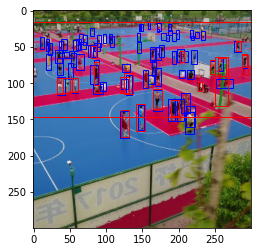

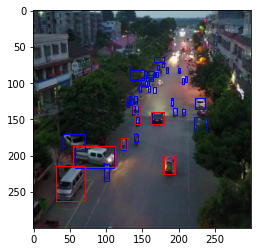

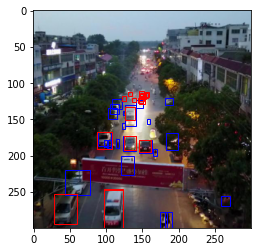

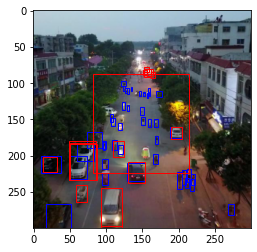

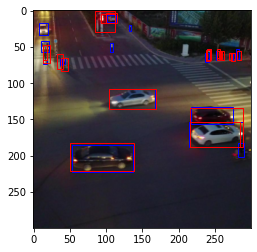

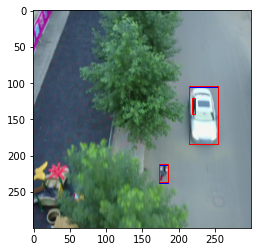

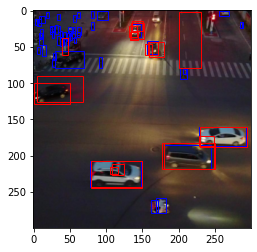

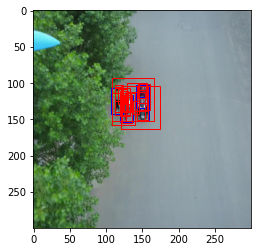

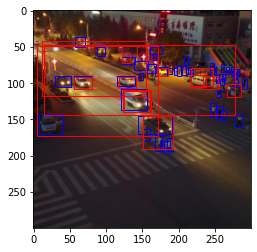

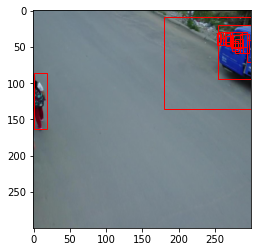

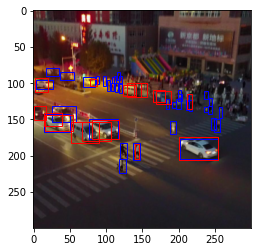

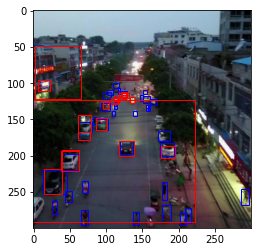

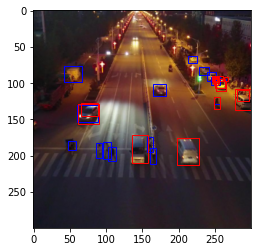

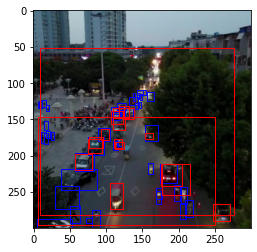

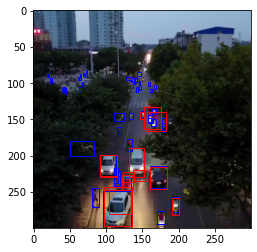

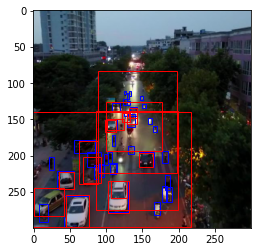

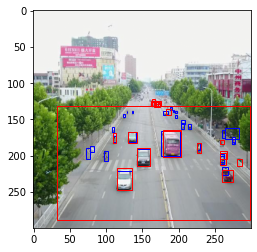

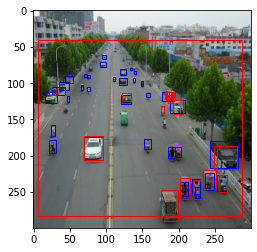

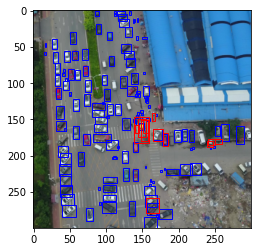

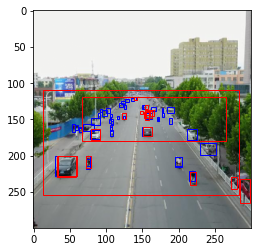

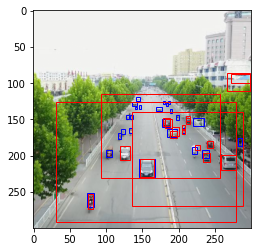

In [156]:
for image_idx in np.arange(50,71,1):
    fig, ax = plt.subplots(1)
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    box = pd.DataFrame()
    name = name_foto[image_idx][0:-4]
    box = df_annotation_true_4.loc[df_annotation_true_4.name_file == name]
    for idx in range(len(box)):
        x1 = box.bbox_left.iloc[idx]
        x2 = box.bbox_top.iloc[idx]
        x3 = box.bbox_width.iloc[idx]
        x4 = box.bbox_height.iloc[idx]
        rect1 = patches.Rectangle((x1, x2), x3, x4, linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect1)
    box1 = pd.DataFrame()
    box1 = df_annotation_received.loc[df_annotation_received.name_file == name]
    for idx in range(len(box1)):
        y1 = box1.bbox_left.iloc[idx]
        y2 = box1.bbox_top.iloc[idx]
        y3 = box1.bbox_width.iloc[idx]
        y4 = box1.bbox_height.iloc[idx]
        rect1 = patches.Rectangle((y1, y2), y3, y4, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect1)
plt.show()

In [0]:
def max_in_list(lst): 
  assert lst
  m = lst[0]
  for i in lst:
    if i > m:
      m = i
  return m

In [0]:
box_in1 = df_annotation_true_4.loc[:,('bbox_left','bbox_top','bbox_width','bbox_height','name_file','object_category')]
box_out1 = df_annotation_received.loc[:,('bbox_left','bbox_top','bbox_width','bbox_height','name_file','classes')]


In [0]:
def IoU_1(out, inp):

  box_in = inp
  box_out = out
  for_return = pd.DataFrame()
  for_return_1 = []
  for_return_2 = []

  for i in range(len(box_out)):
    x_out = box_out.iloc[i,0]
    y_out = box_out.iloc[i,1]
    indx_in = []
    peresec = []
    name_out = box_out.iloc[i,4]

    for j in range(len(box_in)):
      name_in = box_in.iloc[j,4]
      if (name_out == name_in):
        width_out = box_out.iloc[i,2]
        height_out = box_out.iloc[i,3]

        width_in = box_in.iloc[j,2]
        height_in = box_in.iloc[j,3]

        x1_in = box_in.iloc[j,0]
        x2_in = box_in.iloc[j,0] + width_in
          
        y1_in = box_in.iloc[j,1]
        y2_in = box_in.iloc[j,1] - height_in
        
        x1_out = box_out.iloc[i,0]
        x2_out = box_out.iloc[i,0] + width_out
        
        y1_out = box_out.iloc[i,1]
        y2_out = box_out.iloc[i,1] - height_out
        
        xA = max(x1_out, x1_in)
        yA = max(y2_out, y2_in)
        xB = min(x2_out, x2_in)
        yB = min(y1_out, y1_in)

        w_p = xB - xA
        h_p = yB - yA

        if(w_p > 0):
          if(h_p > 0):
            interArea = w_p * h_p
          else:
            interArea = 0
        else:
          interArea = 0

        boxAArea = width_out * height_out
        boxBArea = height_in * width_in
        
        iou = interArea / float(boxAArea + boxBArea - interArea)
        indx_in.append(j)
        peresec.append(iou)

    if(peresec): 
      m_iou = max_in_list(peresec)
      for q in range(len(peresec)):
        if(peresec[q] == m_iou):
          index = indx_in[q]
          m_cl = box_in.iloc[index,5]
    else:
      peresec.append(0)
      m_iou = 0
      m_cl = 'nothing'
    
    
    for_return_1.append(m_iou)
    for_return_2.append(m_cl)

    print(i)
    print(m_iou)
    print('----------------------')
    
  for_return['iou'] = pd.Series(for_return_1)
  for_return['class_def'] = pd.Series(for_return_2)
  return for_return

In [59]:
iou = IoU_1(box_out1,box_in1)

Streaming output truncated to the last 5000 lines.
----------------------
7060
0.05647504078174705
----------------------
7061
0.7541146816360502
----------------------
7062
0.06872870843886197
----------------------
7063
0.0
----------------------
7064
0.14613121055568284
----------------------
7065
0.9211826205963466
----------------------
7066
0.8451215722748533
----------------------
7067
0.934540867753793
----------------------
7068
0.09234498494379942
----------------------
7069
0.886719620815261
----------------------
7070
0.19821379630353478
----------------------
7071
0.5311531794202228
----------------------
7072
0.37061701053183016
----------------------
7073
0.46085041453249626
----------------------
7074
0.8759577144752093
----------------------
7075
0.840808530838592
----------------------
7076
0.6335112840452358
----------------------
7077
0.8569669171986755
----------------------
7078
0.00035658934556129386
----------------------
7079
0.8974280109456659
----------------

In [0]:
iou.to_csv('/content/drive/My Drive/export_iou.csv', index = False, header=True)
df_annotation_true_4.to_csv('/content/drive/My Drive/export_df_annotation_true_4.csv', index = False, header=True)
df_annotation_received.to_csv('/content/drive/My Drive/export_df_annotation_received.csv', index = False, header=True)


In [0]:
iou = pd.read_csv('/content/drive/My Drive/export_iou.csv')
df_annotation_true_4 = pd.read_csv('/content/drive/My Drive/export_df_annotation_true_4.csv')
df_annotation_received = pd.read_csv('/content/drive/My Drive/export_df_annotation_received.csv')

In [67]:
len(iou)

8726

In [61]:
iou[iou.iou > 0.5]

,iou,class_def
13,0.819246,people
14,0.550521,people
15,0.756490,people
17,0.550178,people
18,0.746629,people
...,...,...
8719,0.701108,сar
8720,0.577623,сar
8721,0.778673,сar
8723,0.567020,сar


In [0]:
df_annotation_received_analis = df_annotation_received.copy()

In [77]:
df_annotation_received_analis.index = pd.Series(range(0,8726))
df_annotation_received_analis

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file
0,69.610023,116.437965,236.302475,91.588531,people,0.077123,0000021_00000_d_0000001
1,166.208099,151.490616,6.326044,17.915653,people,0.077328,0000021_00000_d_0000001
2,164.145508,152.750870,3.884482,7.707202,people,0.078046,0000021_00000_d_0000001
3,197.916016,106.741852,2.954435,7.522577,people,0.079415,0000021_00000_d_0000001
4,177.337479,153.866776,6.435835,23.586559,people,0.079492,0000021_00000_d_0000001
...,...,...,...,...,...,...,...
8721,104.299561,139.873718,23.052996,23.386646,сar,0.194866,0000001_05249_d_0000009
8722,196.119827,39.122555,14.690102,12.213180,сar,0.197178,0000001_05249_d_0000009
8723,199.896027,60.889133,13.895166,14.755516,сar,0.249358,0000001_05249_d_0000009
8724,110.667953,73.021454,78.561966,74.463173,bus,0.385268,0000001_05249_d_0000009


In [0]:
df_annotation_received_analis['iou'] = iou.iou
df_annotation_received_analis['class_deff'] = iou.class_def

In [79]:
df_annotation_received_analis

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file,iou,class_deff
0,69.610023,116.437965,236.302475,91.588531,people,0.077123,0000021_00000_d_0000001,0.002827,people
1,166.208099,151.490616,6.326044,17.915653,people,0.077328,0000021_00000_d_0000001,0.309501,people
2,164.145508,152.750870,3.884482,7.707202,people,0.078046,0000021_00000_d_0000001,0.079080,people
3,197.916016,106.741852,2.954435,7.522577,people,0.079415,0000021_00000_d_0000001,0.184535,people
4,177.337479,153.866776,6.435835,23.586559,people,0.079492,0000021_00000_d_0000001,0.000000,people
...,...,...,...,...,...,...,...,...,...
8721,104.299561,139.873718,23.052996,23.386646,сar,0.194866,0000001_05249_d_0000009,0.778673,сar
8722,196.119827,39.122555,14.690102,12.213180,сar,0.197178,0000001_05249_d_0000009,0.251723,сar
8723,199.896027,60.889133,13.895166,14.755516,сar,0.249358,0000001_05249_d_0000009,0.567020,сar
8724,110.667953,73.021454,78.561966,74.463173,bus,0.385268,0000001_05249_d_0000009,0.044345,сar


In [0]:
df_annotation_received_analis.to_csv('/content/drive/My Drive/export_df_annotation_received_analis.csv', index = False, header=True)

In [81]:
df_annotation_received_analis['val'] = pd.Series()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [82]:
for i in range(len(df_annotation_received_analis)):
  if(df_annotation_received_analis.classes.iloc[i] == df_annotation_received_analis.class_deff.iloc[i]):
    df_annotation_received_analis['val'].iloc[i] = 1
  else:
    df_annotation_received_analis['val'].iloc[i] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [83]:
df_annotation_received_analis

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file,iou,class_deff,val
0,69.610023,116.437965,236.302475,91.588531,people,0.077123,0000021_00000_d_0000001,0.002827,people,1.0
1,166.208099,151.490616,6.326044,17.915653,people,0.077328,0000021_00000_d_0000001,0.309501,people,1.0
2,164.145508,152.750870,3.884482,7.707202,people,0.078046,0000021_00000_d_0000001,0.079080,people,1.0
3,197.916016,106.741852,2.954435,7.522577,people,0.079415,0000021_00000_d_0000001,0.184535,people,1.0
4,177.337479,153.866776,6.435835,23.586559,people,0.079492,0000021_00000_d_0000001,0.000000,people,1.0
...,...,...,...,...,...,...,...,...,...,...
8721,104.299561,139.873718,23.052996,23.386646,сar,0.194866,0000001_05249_d_0000009,0.778673,сar,1.0
8722,196.119827,39.122555,14.690102,12.213180,сar,0.197178,0000001_05249_d_0000009,0.251723,сar,1.0
8723,199.896027,60.889133,13.895166,14.755516,сar,0.249358,0000001_05249_d_0000009,0.567020,сar,1.0
8724,110.667953,73.021454,78.561966,74.463173,bus,0.385268,0000001_05249_d_0000009,0.044345,сar,0.0


In [84]:
df_annotation_received_analis.loc[df_annotation_received_analis.val == 1].count()

bbox_left      6437
bbox_top       6437
bbox_width     6437
bbox_height    6437
classes        6437
confidences    6437
name_file      6437
iou            6437
class_deff     6437
val            6437
dtype: int64

In [85]:
df_annotation_received_analis.loc[(df_annotation_received_analis.iou > 0.5) & (df_annotation_received_analis.val == 1)]

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file,iou,class_deff,val
13,162.542389,148.684540,8.852577,32.923767,people,0.353459,0000021_00000_d_0000001,0.819246,people,1.0
14,141.803375,139.658783,7.827687,28.213942,people,0.449006,0000021_00000_d_0000001,0.550521,people,1.0
15,150.744568,149.660660,10.769677,33.315434,people,0.963663,0000021_00000_d_0000001,0.756490,people,1.0
17,253.247757,116.341927,4.338062,10.542637,people,0.109001,0000022_00000_d_0000004,0.550178,people,1.0
18,195.777939,131.615875,8.399105,16.158110,people,0.111698,0000022_00000_d_0000004,0.746629,people,1.0
...,...,...,...,...,...,...,...,...,...,...
8719,93.370415,44.351250,15.387922,13.063762,сar,0.161494,0000001_05249_d_0000009,0.701108,сar,1.0
8720,179.703995,57.560574,13.941479,12.357410,сar,0.185778,0000001_05249_d_0000009,0.577623,сar,1.0
8721,104.299561,139.873718,23.052996,23.386646,сar,0.194866,0000001_05249_d_0000009,0.778673,сar,1.0
8723,199.896027,60.889133,13.895166,14.755516,сar,0.249358,0000001_05249_d_0000009,0.567020,сar,1.0


In [149]:
df_annotation_received_analis.loc[df_annotation_received_analis.classes == 'bycycle']

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file,iou,class_deff,val
12,181.771286,196.610397,43.210175,33.105217,bycycle,0.177220,0000021_00000_d_0000001,0.000000,people,0.0
112,7.847517,155.742065,28.581303,15.172327,bycycle,0.323823,0000022_01036_d_0000006,0.058509,people,0.0
132,4.939372,128.905289,26.134935,16.557777,bycycle,0.093082,0000022_01251_d_0000007,0.000000,people,0.0
139,1.492797,116.535301,27.448784,29.522484,bycycle,0.307218,0000022_01251_d_0000007,0.289032,people,0.0
166,12.649544,197.032104,26.245737,15.051055,bycycle,0.092251,0000024_00000_d_0000012,0.000000,people,0.0
171,92.764694,168.864838,16.492689,23.015177,bycycle,0.128668,0000024_00000_d_0000012,0.386215,people,0.0
245,2.469511,195.411850,33.356319,34.424973,bycycle,0.325371,0000023_00868_d_0000010,0.000000,people,0.0
278,1.496887,122.186348,54.393608,58.679726,bycycle,0.093729,0000023_01233_d_0000011,0.266887,people,0.0
282,-0.728983,142.789993,23.850975,16.119934,bycycle,0.100806,0000023_01233_d_0000011,0.000000,people,0.0
286,1.966673,139.954346,24.860863,14.570806,bycycle,0.177548,0000023_01233_d_0000011,0.000000,people,0.0


In [86]:
df_annotation_received_analis_0_5 = df_annotation_received_analis.loc[df_annotation_received_analis.iou > 0.5]
df_annotation_received_analis_0_5

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file,iou,class_deff,val
13,162.542389,148.684540,8.852577,32.923767,people,0.353459,0000021_00000_d_0000001,0.819246,people,1.0
14,141.803375,139.658783,7.827687,28.213942,people,0.449006,0000021_00000_d_0000001,0.550521,people,1.0
15,150.744568,149.660660,10.769677,33.315434,people,0.963663,0000021_00000_d_0000001,0.756490,people,1.0
17,253.247757,116.341927,4.338062,10.542637,people,0.109001,0000022_00000_d_0000004,0.550178,people,1.0
18,195.777939,131.615875,8.399105,16.158110,people,0.111698,0000022_00000_d_0000004,0.746629,people,1.0
...,...,...,...,...,...,...,...,...,...,...
8719,93.370415,44.351250,15.387922,13.063762,сar,0.161494,0000001_05249_d_0000009,0.701108,сar,1.0
8720,179.703995,57.560574,13.941479,12.357410,сar,0.185778,0000001_05249_d_0000009,0.577623,сar,1.0
8721,104.299561,139.873718,23.052996,23.386646,сar,0.194866,0000001_05249_d_0000009,0.778673,сar,1.0
8723,199.896027,60.889133,13.895166,14.755516,сar,0.249358,0000001_05249_d_0000009,0.567020,сar,1.0


In [87]:
df_annotation_received_analis_0_75 = df_annotation_received_analis.loc[df_annotation_received_analis.iou > 0.75]
df_annotation_received_analis_0_75

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file,iou,class_deff,val
13,162.542389,148.684540,8.852577,32.923767,people,0.353459,0000021_00000_d_0000001,0.819246,people,1.0
15,150.744568,149.660660,10.769677,33.315434,people,0.963663,0000021_00000_d_0000001,0.756490,people,1.0
73,67.815483,174.484238,31.605793,28.630543,сar,0.191831,0000001_08414_d_0000013,0.962666,сar,1.0
75,67.815483,174.484238,31.605793,28.630543,trunck,0.211554,0000001_08414_d_0000013,0.962666,сar,0.0
77,40.655300,197.924255,33.420433,32.321404,сar,0.285855,0000001_08414_d_0000013,0.821274,сar,1.0
...,...,...,...,...,...,...,...,...,...,...
8698,234.753250,231.573990,38.276981,32.215439,сar,0.344388,0000001_05999_d_0000011,0.972812,сar,1.0
8707,106.543098,126.581024,17.932802,17.186541,сar,0.705198,0000001_05999_d_0000011,0.852168,сar,1.0
8718,122.770912,75.596596,17.175882,14.599264,сar,0.160221,0000001_05249_d_0000009,0.831810,сar,1.0
8721,104.299561,139.873718,23.052996,23.386646,сar,0.194866,0000001_05249_d_0000009,0.778673,сar,1.0


In [88]:
df_annotation_received_analis_0_9 = df_annotation_received_analis.loc[df_annotation_received_analis.iou > 0.9]
df_annotation_received_analis_0_9

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file,iou,class_deff,val
73,67.815483,174.484238,31.605793,28.630543,сar,0.191831,0000001_08414_d_0000013,0.962666,сar,1.0
75,67.815483,174.484238,31.605793,28.630543,trunck,0.211554,0000001_08414_d_0000013,0.962666,сar,0.0
78,58.150845,161.730026,26.944372,21.585953,trunck,0.317441,0000001_08414_d_0000013,0.926132,сar,0.0
179,118.238884,159.650253,10.811895,31.268906,people,0.654011,0000024_00000_d_0000012,0.914152,people,1.0
183,17.327042,229.399399,40.892036,68.156792,сar,0.176238,0000026_00500_d_0000025,0.921960,сar,1.0
...,...,...,...,...,...,...,...,...,...,...
8644,145.806137,98.359970,12.448713,18.767845,сar,0.118101,0000001_03499_d_0000006,0.953998,сar,1.0
8666,268.403473,89.699791,15.329289,16.803593,сar,0.299568,0000001_05499_d_0000010,0.934490,сar,1.0
8668,43.025967,221.008957,29.942232,30.303490,trunck,0.341397,0000001_05499_d_0000010,0.907260,сar,0.0
8672,43.025967,221.008957,29.942232,30.303490,сar,0.496130,0000001_05499_d_0000010,0.907260,сar,1.0


In [0]:
task_4 = pd.DataFrame()
task_5 = pd.DataFrame()

In [90]:
col_in = df_annotation_true_4.groupby(['name_file'], as_index = False).object_category.count()
col_in.columns = ['name_file','count_box_in']
col_in

,name_file,count_box_in
0,0000001_02999_d_0000005,55
1,0000001_03499_d_0000006,45
2,0000001_03999_d_0000007,30
3,0000001_04527_d_0000008,57
4,0000001_05249_d_0000009,80
...,...,...
540,0000364_00589_d_0000798,33
541,0000364_01177_d_0000799,45
542,0000364_01373_d_0000780,31
543,0000364_01569_d_0000781,53


In [92]:
col_in_for_clas = df_annotation_true_4.groupby(['name_file','object_category'], as_index = False).bbox_height.count()
col_in_for_clas.columns = ['name_file','classes_in','count_box_in']
col_in_for_clas

,name_file,classes_in,count_box_in
0,0000001_02999_d_0000005,bycycle,2
1,0000001_02999_d_0000005,people,38
2,0000001_02999_d_0000005,trunck,1
3,0000001_02999_d_0000005,сar,14
4,0000001_03499_d_0000006,bycycle,1
...,...,...,...
1650,0000364_01569_d_0000781,сar,3
1651,0000364_01765_d_0000782,bus,1
1652,0000364_01765_d_0000782,people,41
1653,0000364_01765_d_0000782,trunck,2


In [93]:
 total_count_0_5_out_corect = df_annotation_received_analis_0_5.val.sum()
 total_count_0_5_out_corect

3014.0

In [94]:
 total_count_0_75_out_corect = df_annotation_received_analis_0_75.val.sum()
 total_count_0_75_out_corect

1288.0

In [95]:
 total_count_0_9_out_corect = df_annotation_received_analis_0_9.val.sum()
 total_count_0_9_out_corect

181.0

In [0]:
total_count_0_5_out = df_annotation_received_analis_0_5.classes.count()
total_count_0_75_out = df_annotation_received_analis_0_75.classes.count()
total_count_0_9_out = df_annotation_received_analis_0_9.classes.count()
total = col_in.count_box_in.sum()
total_in = df_annotation_received_analis.name_file.count()


In [0]:
lost_0_5 = total -  total_count_0_5_out_corect
lost_0_75 = total -  total_count_0_75_out_corect
lost_0_9 = total -  total_count_0_9_out_corect
false_def_0_5 = total_in - total_count_0_5_out_corect
false_def_0_75 = total_in - total_count_0_75_out_corect
false_def_0_9 = total_in - total_count_0_9_out_corect

In [0]:
acc_0_5 = total_count_0_5_out_corect / total_count_0_5_out * 100
acc_0_75 = total_count_0_75_out_corect / total_count_0_75_out * 100
acc_0_9 = total_count_0_9_out_corect / total_count_0_9_out * 100

In [0]:
task_4['accuracy'] = pd.Series([acc_0_5, acc_0_75, acc_0_9])
task_4['lost'] = pd.Series([lost_0_5, lost_0_75, lost_0_9])
task_4['false'] = pd.Series([false_def_0_5, false_def_0_75, false_def_0_9])

In [100]:
task_4.index = ['0,5','0,75','0,9']
task_4

,accuracy,lost,false
"0,5",83.513439,19400.0,5712.0
"0,75",77.637131,21126.0,7438.0
"0,9",75.416667,22233.0,8545.0


In [126]:
df_annotation_received_analis_0_5.loc[df_annotation_received_analis_0_5.classes == 'car']

,bbox_left,bbox_top,bbox_width,bbox_height,classes,confidences,name_file,iou,class_deff,val


In [0]:
total_count_0_5_out_corect_people = df_annotation_received_analis_0_5.loc[df_annotation_received_analis_0_5.classes == 'people'].val.sum()
total_count_0_5_out_corect_bicycle= df_annotation_received_analis_0_5.loc[df_annotation_received_analis_0_5.classes == 'bycycle'].val.sum()
total_count_0_5_out_corect_car = df_annotation_received_analis_0_5.loc[df_annotation_received_analis_0_5.classes == 'сar'].val.sum()
total_count_0_5_out_corect_bus = df_annotation_received_analis_0_5.loc[df_annotation_received_analis_0_5.classes == 'bus'].val.sum()
total_count_0_5_out_corect_trunck = df_annotation_received_analis_0_5.loc[df_annotation_received_analis_0_5.classes == 'trunck'].val.sum()

In [146]:
total_count_0_5_out_corect_bicycle

0.0

In [0]:
total_count_0_75_out_corect_people = df_annotation_received_analis_0_75.loc[df_annotation_received_analis_0_75.classes == 'people'].val.sum()
total_count_0_75_out_corect_bicycle= df_annotation_received_analis_0_75.loc[df_annotation_received_analis_0_75.classes == 'bycycle'].val.sum()
total_count_0_75_out_corect_car = df_annotation_received_analis_0_75.loc[df_annotation_received_analis_0_75.classes == 'сar'].val.sum()
total_count_0_75_out_corect_bus = df_annotation_received_analis_0_75.loc[df_annotation_received_analis_0_75.classes == 'bus'].val.sum()
total_count_0_75_out_corect_trunck = df_annotation_received_analis_0_75.loc[df_annotation_received_analis_0_75.classes == 'trunck'].val.sum()

In [0]:
total_count_0_9_out_corect_people = df_annotation_received_analis_0_9.loc[df_annotation_received_analis_0_9.classes == 'people'].val.sum()
total_count_0_9_out_corect_bicycle= df_annotation_received_analis_0_9.loc[df_annotation_received_analis_0_9.classes == 'bycycle'].val.sum()
total_count_0_9_out_corect_car = df_annotation_received_analis_0_9.loc[df_annotation_received_analis_0_9.classes == 'сar'].val.sum()
total_count_0_9_out_corect_bus = df_annotation_received_analis_0_9.loc[df_annotation_received_analis_0_9.classes == 'bus'].val.sum()
total_count_0_9_out_corect_trunck = df_annotation_received_analis_0_9.loc[df_annotation_received_analis_0_9.classes == 'trunck'].val.sum()

In [0]:
total_count_0_5_out_people = df_annotation_received_analis_0_5.loc[df_annotation_received_analis_0_5.classes == 'people'].val.count()
total_count_0_5_out_bicycle= df_annotation_received_analis_0_5.loc[df_annotation_received_analis_0_5.classes == 'bycycle'].val.count()
total_count_0_5_out_car = df_annotation_received_analis_0_5.loc[df_annotation_received_analis_0_5.classes == 'сar'].val.count()
total_count_0_5_out_bus = df_annotation_received_analis_0_5.loc[df_annotation_received_analis_0_5.classes == 'bus'].val.count()
total_count_0_5_out_trunck = df_annotation_received_analis_0_5.loc[df_annotation_received_analis_0_5.classes == 'trunck'].val.count()

total_count_0_75_out_people = df_annotation_received_analis_0_75.loc[df_annotation_received_analis_0_75.classes == 'people'].val.count()
total_count_0_75_out_bicycle= df_annotation_received_analis_0_75.loc[df_annotation_received_analis_0_75.classes == 'bycycle'].val.count()
total_count_0_75_out_car = df_annotation_received_analis_0_75.loc[df_annotation_received_analis_0_75.classes == 'сar'].val.count()
total_count_0_75_out_bus = df_annotation_received_analis_0_75.loc[df_annotation_received_analis_0_75.classes == 'bus'].val.count()
total_count_0_75_out_trunck = df_annotation_received_analis_0_75.loc[df_annotation_received_analis_0_75.classes == 'trunck'].val.count()

total_count_0_9_out_people = df_annotation_received_analis_0_9.loc[df_annotation_received_analis_0_9.classes == 'people'].val.count()
total_count_0_9_out_bicycle= df_annotation_received_analis_0_9.loc[df_annotation_received_analis_0_9.classes == 'bycycle'].val.count()
total_count_0_9_out_car = df_annotation_received_analis_0_9.loc[df_annotation_received_analis_0_9.classes == 'сar'].val.count()
total_count_0_9_out_bus = df_annotation_received_analis_0_9.loc[df_annotation_received_analis_0_9.classes == 'bus'].val.count()
total_count_0_9_out_trunck = df_annotation_received_analis_0_9.loc[df_annotation_received_analis_0_9.classes == 'trunck'].val.count()

total_people = col_in_for_clas.loc[col_in_for_clas.classes_in == 'people'].count_box_in.sum()
total_bicycle = col_in_for_clas.loc[col_in_for_clas.classes_in == 'bycycle'].count_box_in.sum()
total_car = col_in_for_clas.loc[col_in_for_clas.classes_in ==  'сar'].count_box_in.sum()
total_bus = col_in_for_clas.loc[col_in_for_clas.classes_in == 'bus'].count_box_in.sum()
total_trunck = col_in_for_clas.loc[col_in_for_clas.classes_in == 'trunck'].count_box_in.sum()

total_in_people = df_annotation_received_analis.loc[df_annotation_received_analis.classes == 'people'].name_file.count()
total_in_bicycle = df_annotation_received_analis.loc[df_annotation_received_analis.classes == 'bycycle'].name_file.count()
total_in_car = df_annotation_received_analis.loc[df_annotation_received_analis.classes  == 'сar'].name_file.count()
total_in_bus = df_annotation_received_analis.loc[df_annotation_received_analis.classes == 'bus'].name_file.count()
total_in_trunck = df_annotation_received_analis.loc[df_annotation_received_analis.classes == 'trunck'].name_file.count()

In [0]:
lost_0_5_people = total_people -  total_count_0_5_out_corect_people
lost_0_75_people = total_people -  total_count_0_75_out_corect_people
lost_0_9_people= total_people -  total_count_0_9_out_corect_people

lost_0_5_bicycle = total_bicycle -  total_count_0_5_out_corect_bicycle
lost_0_75_bicycle = total_bicycle -  total_count_0_75_out_corect_bicycle
lost_0_9_bicycle = total_bicycle -  total_count_0_9_out_corect_bicycle

lost_0_5_car = total_car -  total_count_0_5_out_corect_car
lost_0_75_car = total_car -  total_count_0_75_out_corect_car
lost_0_9_car = total_car -  total_count_0_9_out_corect_car

lost_0_5_bus = total_bus -  total_count_0_5_out_corect_bus
lost_0_75_bus = total_bus -  total_count_0_75_out_corect_bus
lost_0_9_bus= total_bus -  total_count_0_9_out_corect_bus

lost_0_5_trunck  = total_trunck  -  total_count_0_5_out_corect_trunck 
lost_0_75_trunck  = total_trunck  -  total_count_0_75_out_corect_trunck 
lost_0_9_trunck = total_trunck  -  total_count_0_9_out_corect_trunck 

In [0]:
false_def_0_5_people = total_in_people - total_count_0_5_out_corect_people
false_def_0_75_people = total_in_people - total_count_0_75_out_corect_people
false_def_0_9_people = total_in_people - total_count_0_9_out_corect_people

false_def_0_5_bicycle = total_in_bicycle - total_count_0_5_out_corect_bicycle
false_def_0_75_bicycle = total_in_bicycle - total_count_0_75_out_corect_bicycle
false_def_0_9_bicycle = total_in_bicycle - total_count_0_9_out_corect_bicycle

false_def_0_5_car = total_in_car - total_count_0_5_out_corect_car
false_def_0_75_car = total_in_car - total_count_0_75_out_corect_car
false_def_0_9_car = total_in_car - total_count_0_9_out_corect_car

false_def_0_5_bus = total_in_bus - total_count_0_5_out_corect_bus
false_def_0_75_bus = total_in_bus - total_count_0_75_out_corect_bus
false_def_0_9_bus = total_in_bus - total_count_0_9_out_corect_bus

false_def_0_5_trunck  = total_in_trunck  - total_count_0_5_out_corect_trunck 
false_def_0_75_trunck  = total_in_trunck  - total_count_0_75_out_corect_trunck 
false_def_0_9_trunck  = total_in_trunck  - total_count_0_9_out_corect_trunck 

In [141]:
acc_0_5_people = total_count_0_5_out_corect_people / total_count_0_5_out_people * 100
acc_0_75_people = total_count_0_75_out_corect_people / total_count_0_75_out_people * 100
acc_0_9_people = total_count_0_9_out_corect_people / total_count_0_9_out_people * 100

acc_0_5_bicycle = total_count_0_5_out_corect_bicycle/ total_count_0_5_out_bicycle * 100
acc_0_75_bicycle = total_count_0_75_out_corect_bicycle / total_count_0_75_out_bicycle * 100
acc_0_9_bicycle = total_count_0_9_out_corect_bicycle / total_count_0_9_out_bicycle * 100

acc_0_5_car = total_count_0_5_out_corect_car / total_count_0_5_out_car * 100
acc_0_75_car = total_count_0_75_out_corect_car / total_count_0_75_out_car * 100
acc_0_9_car = total_count_0_9_out_corect_car / total_count_0_9_out_car * 100

acc_0_5_bus = total_count_0_5_out_corect_bus / total_count_0_5_out_bus * 100
acc_0_75_bus = total_count_0_75_out_corect_bus / total_count_0_75_out_bus * 100
acc_0_9_bus = total_count_0_9_out_corect_bus / total_count_0_9_out_bus * 100

acc_0_5_trunck = total_count_0_5_out_corect_trunck / total_count_0_5_out_trunck * 100
acc_0_75_trunck = total_count_0_75_out_corect_trunck / total_count_0_75_out_trunck * 100
acc_0_9_trunck = total_count_0_9_out_corect_trunck / total_count_0_9_out_trunck * 100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [0]:
task_5 = pd.DataFrame()

In [0]:
task_5['class'] = ['people', 'people', 'people',
                   'bycycle', 'bycycle', 'bycycle',
                   'car', 'car', 'car',
                   'bus', 'bus', 'bus',
                   'trunck', 'trunck', 'trunck']

task_5['iou'] = ['0.5', '0.75', '0.9',
                   '0.5', '0.75', '0.9',
                   '0.5', '0.75', '0.9',
                   '0.5', '0.75', '0.9',
                   '0.5', '0.75', '0.9']

In [0]:
task_5['accuracy'] = pd.Series([acc_0_5_people, acc_0_75_people, acc_0_9_people, acc_0_5_bicycle, acc_0_75_bicycle, acc_0_9_bicycle,
                                acc_0_5_car, acc_0_75_car, acc_0_9_car, acc_0_5_bus, acc_0_75_bus, acc_0_9_bus,
                                acc_0_5_trunck, acc_0_75_trunck, acc_0_9_trunck])
task_5['lost'] = pd.Series([lost_0_5_people, lost_0_75_people, lost_0_9_people, lost_0_5_bicycle, lost_0_75_bicycle, lost_0_9_bicycle,
                            lost_0_5_car, lost_0_75_car, lost_0_9_car, lost_0_5_bus, lost_0_75_bus, lost_0_9_bus,
                            lost_0_5_trunck, lost_0_75_trunck, lost_0_9_trunck])
task_5['false'] = pd.Series([false_def_0_5_people, false_def_0_75_people, false_def_0_9_people, false_def_0_5_bicycle, false_def_0_75_bicycle, false_def_0_9_bicycle,
                             false_def_0_5_car , false_def_0_75_car , false_def_0_9_car , false_def_0_5_bus, false_def_0_75_bus, false_def_0_9_bus,
                             false_def_0_5_trunck, false_def_0_75_trunck, false_def_0_9_trunck])

In [145]:
task_5.fillna(0) 

,class,iou,accuracy,lost,false
0,people,0.5,98.706100,9374.0,1264.0
1,people,0.75,98.412698,9784.0,1674.0
2,people,0.9,90.909091,9898.0,1788.0
3,bycycle,0.5,0.000000,851.0,28.0
4,bycycle,0.75,0.000000,851.0,28.0
5,bycycle,0.9,0.000000,851.0,28.0
6,car,0.5,94.962613,8492.0,3652.0
7,car,0.75,96.972318,9784.0,4944.0
8,car,0.9,98.809524,10739.0,5899.0
9,bus,0.5,30.909091,196.0,76.0


In [0]:
df_annotation_received_analis_0_1 = df_annotation_received_analis.loc[df_annotation_received_analis.iou > 0.1]
df_annotation_received_analis_0_3 = df_annotation_received_analis.loc[df_annotation_received_analis.iou > 0.3]

In [0]:
total_count_0_3_out_corect = df_annotation_received_analis_0_3.val.sum()
total_count_0_1_out_corect = df_annotation_received_analis_0_1.val.sum()
total_corect = df_annotation_received_analis.val.sum()

In [114]:
print(total_count_0_3_out_corect )
print(total_count_0_1_out_corect )
print(total_corect)

4335.0
5350.0
6437.0


In [115]:
total_count_0_1_out = df_annotation_received_analis_0_1.classes.count()
total_count_0_3_out = df_annotation_received_analis_0_3.classes.count()
total = col_in.count_box_in.sum()
total_in = df_annotation_received_analis.name_file.count()
print(total_count_0_1_out)
print(total_count_0_3_out)
print(total_in)

6446
5108
8726


In [0]:
lost_0_1 = total -  total_count_0_1_out_corect
lost_0_3 = total -  total_count_0_3_out_corect
false_def_0_1 = total_in  - total_count_0_1_out 
false_def_0_3= total_in  - total_count_0_3_out

In [0]:
acc_0_1 = total_count_0_1_out_corect / total_count_0_1_out * 100
acc_0_3 = total_count_0_3_out_corect / total_count_0_3_out * 100

In [0]:
task_6 = pd.DataFrame()

In [0]:
task_6['accuracy'] = pd.Series([acc_0_1, acc_0_3])
task_6['lost'] = pd.Series([lost_0_1, lost_0_3])
task_6['false'] = pd.Series([false_def_0_1, false_def_0_3])

In [120]:
task_6.index = ['0,1','0,3']
task_6

,accuracy,lost,false
"0,1",82.997208,17064.0,2280
"0,3",84.866875,18079.0,3618
